<ipython-input-3-bde3cc3575ac>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[target_variable] = np.log1p(df_cleaned[target_variable])


Training Time: 36.48320817947388 seconds
Estimated Space Complexity: 102976 bytes
Root Mean Squared Error (Random Forest): 38669.73830377968
R-squared Score (Random Forest): 0.8050475794521416
Mean Squared Error (Random Forest): 1495348660.4828057
Mean Absolute Error (Random Forest): 24287.171292307903
Explained Variance Score (Random Forest): 0.8066622381826847
Mean Squared Logarithmic Error (Random Forest): 0.03706697565369225


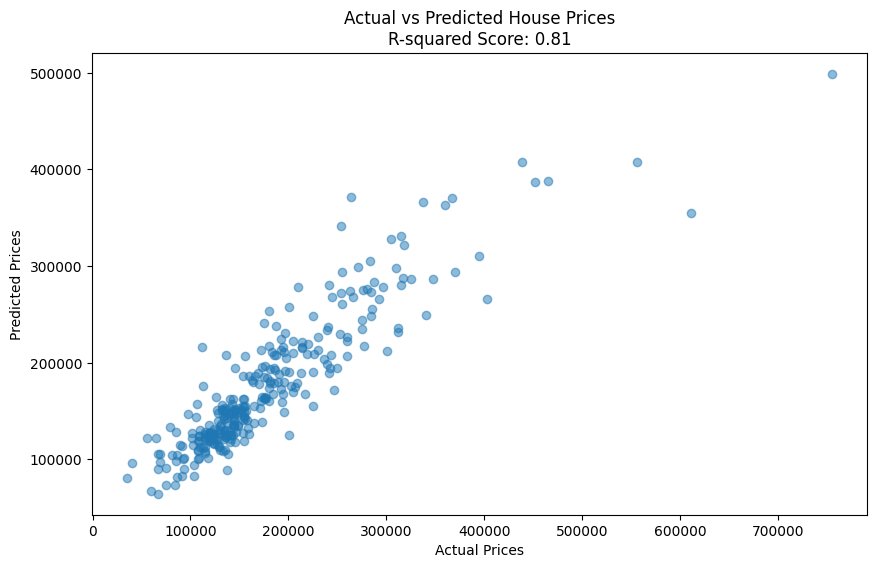

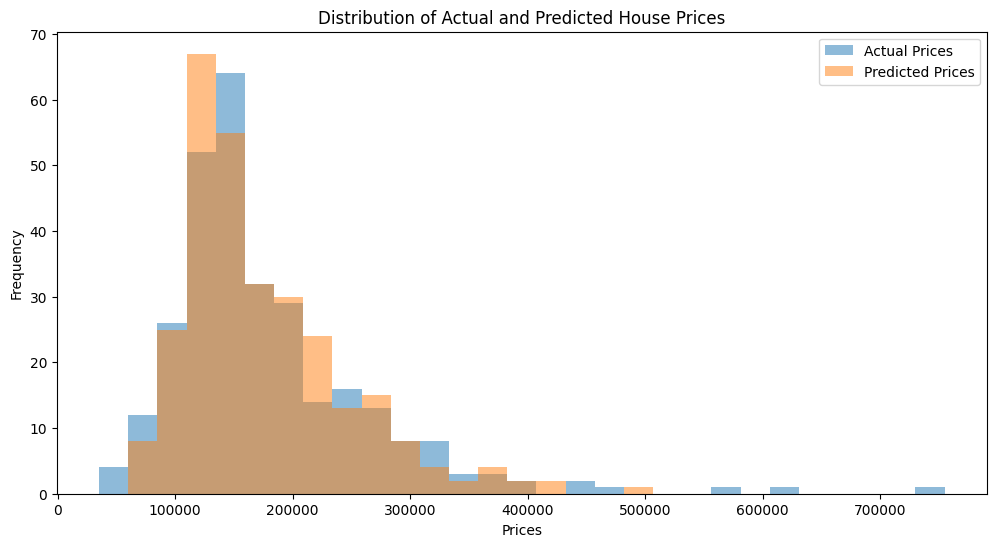

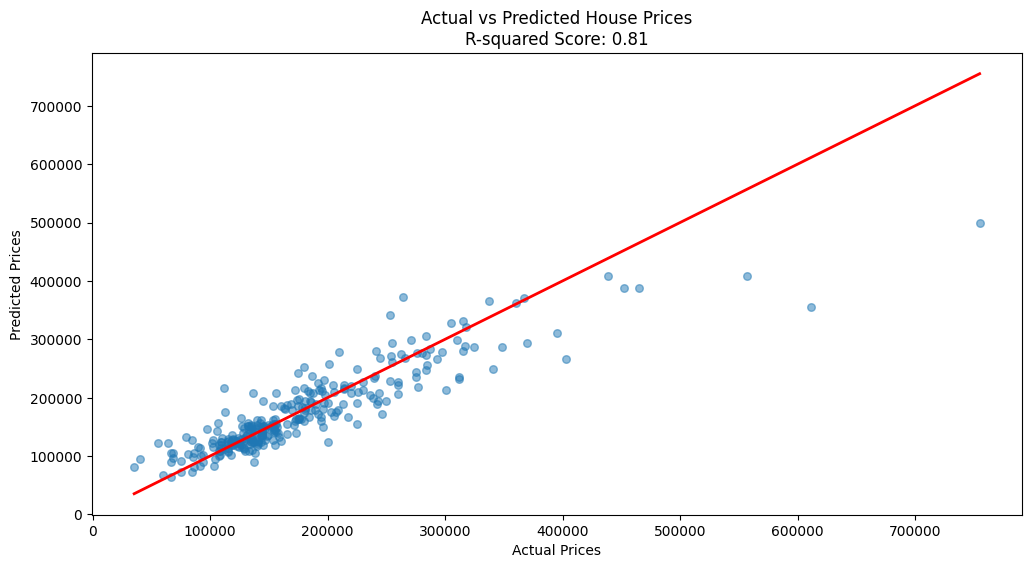

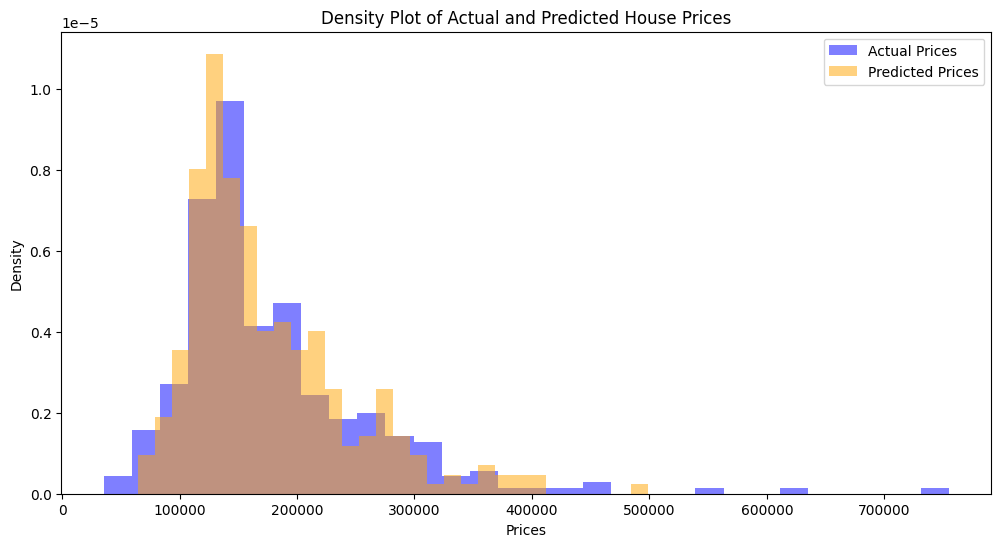

<Figure size 1000x600 with 0 Axes>

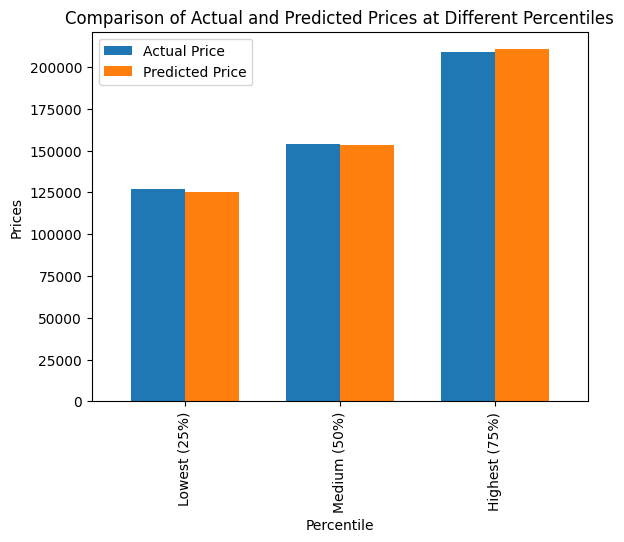

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #needed library for the graph generation
from sklearn.ensemble import RandomForestRegressor

"""
The following library is used for splitting the data and for model
prediction algorithm
"""
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer  #library for handling the missing values
from sklearn.preprocessing import StandardScaler #library for data preprocessing

'''

the following libraries are used for generating the benchmark of
the developed model

'''

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_log_error

import sys #library used in space complexity


# load the data from  the excel file
file_path = r"/content/housing-data-full.xlsx"
df = pd.read_excel(file_path)

# selection of the features and the target variable
selected_features = ['Id','LotArea','OverallQual','OverallCond','YearBuilt',
                     'FullBath','BedroomAbvGr','GarageArea','PoolArea']
target_variable = 'SalePrice'

# subset the DataFrame with the selected features
df_cleaned = df[selected_features + [target_variable]]

# drop the rows with missing values
df_cleaned = df_cleaned.dropna()

'''target_variable is prepared for the model prediction by
using log transformation. It makes the
distribution of the data more symmetric and helps
mitigating the outliers such as the higher price houses '''
df_cleaned[target_variable] = np.log1p(df_cleaned[target_variable])

# define features (X) and the target variable (y)
X = df_cleaned[selected_features]
y = df_cleaned[target_variable]

# spliting the data into training and testing sets (80% training, 2 0% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# handle missing values function using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

'''scale numerical features using StandardScaler. Its the first
step in regard of processing the data for the model prediction'''
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# the hyperparameters used in tuning for Random Forest with an extended search space
param_grid_rf = {
    'n_estimators': [7, 10, 11,],    #number of trees in the forest
    'max_depth': [None, 2, 3, 5],    #depth of each tree
    'min_samples_split': [2, 5, 7,], #min number of samples for splitting
    'min_samples_leaf': [2, 3, 4]    #min number of samples in the node
}

#initialize RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

#record the start time
start_time = time.time()

#GridSearchCV is used for finding the best hyperparameters
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train_scaled, y_train)

#record the end time
end_time = time.time()

#calculate the training time of the model
training_time = end_time - start_time
print(f'Training Time: {training_time} seconds')

#get the best Random Forest model from the grid search function
best_rf_model = grid_search_rf.best_estimator_

#make predictions based on the test set
y_pred = best_rf_model.predict(X_test_scaled)

# reversing the log transformation from before for evaluation
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred)

#size of the Random Forest model
memory_usage = sys.getsizeof(X_train_scaled) + sys.getsizeof(y_train) + sys.getsizeof(best_rf_model)
print(f'Estimated Space Complexity: {memory_usage} bytes')

#evaluating the model
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
evs = explained_variance_score(y_test_original, y_pred_original)
msle = mean_squared_log_error(y_test_original, y_pred_original)

print(f'Root Mean Squared Error (Random Forest): {rmse}')
print(f'R-squared Score (Random Forest): {r2}')
print(f'Mean Squared Error (Random Forest): {mse}')
print(f'Mean Absolute Error (Random Forest): {mae}')
print(f'Explained Variance Score (Random Forest): {evs}')
print(f'Mean Squared Logarithmic Error (Random Forest): {msle}')

# visualize actual vs predicted prices using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.title(f'Actual vs Predicted House Prices\nR-squared Score: {r2:.2f}')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

# histogram for comparing the actual and predicted prices
plt.figure(figsize=(12, 6))
bin_edges = np.linspace(min(y_test_original.min(), y_pred_original.min()), max(y_test_original.max(), y_pred_original.max()), 30)
plt.hist(y_test_original, bins=bin_edges, alpha=0.5, label='Actual Prices')
plt.hist(y_pred_original, bins=bin_edges, alpha=0.5, label='Predicted Prices')
plt.title('Distribution of Actual and Predicted House Prices')
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#visualize actual vs predicted prices using a scatter plot with a regression line
plt.figure(figsize=(12, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5, s=30, )
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linewidth=2)
plt.title(f'Actual vs Predicted House Prices\nR-squared Score: {r2:.2f}')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

# density plot for the actual and predicted prices comparison
plt.figure(figsize=(12, 6))
plt.hist(y_test_original, bins=30, alpha=0.5, density=True, label='Actual Prices', color='blue')
plt.hist(y_pred_original, bins=30, alpha=0.5, density=True, label='Predicted Prices', color='orange')
plt.title('Density Plot of Actual and Predicted House Prices')
plt.xlabel('Prices')
plt.ylabel('Density')
plt.legend()
plt.show()

'''
The next section is for showing the price prediction and doing a precentile
comparison
'''

percentiles_actual = np.percentile(y_test_original, [25, 50, 75])
percentiles_predicted = np.percentile(y_pred_original, [25, 50, 75])

# creating a new data frame for the lowest, medium, and highest predicted prices
comparison_df = pd.DataFrame({
    'Percentile': ['Lowest (25%)', 'Medium (50%)', 'Highest (75%)'],
    'Actual Price': percentiles_actual,
    'Predicted Price': percentiles_predicted
})

# bar plot for comparing actual and predicted prices
plt.figure(figsize=(10, 6))
comparison_df.plot(x='Percentile', y=['Actual Price', 'Predicted Price'], kind='bar', width=0.7)
plt.title('Comparison of Actual and Predicted Prices at Different Percentiles')
plt.xlabel('Percentile')
plt.ylabel('Prices')
plt.show()


# Secțiune nouă